In [6]:
import sgkit as sg
import pandas as pd
import numpy as np
import zarr
import xarray as xr
import allel

In [3]:
with open("/Users/christinagkertsou/Desktop/Finalyearproject/AgamP4.sizes", 'r') as f:
    sizes = f.readlines()


sizes_dict = {}

for size in sizes:
    chrom, lenght = size.split()

    sizes_dict[chrom] = int(lenght)

sizes_dict

{'AgamP4_2L': 49364325,
 'AgamP4_2R': 61545105,
 'AgamP4_3L': 41963435,
 'AgamP4_3R': 53200684,
 'AgamP4_UNKN': 42389979,
 'AgamP4_X': 24393108,
 'AgamP4_Y_unplaced': 237045,
 'AgamP4_Mt': 15363}

In [7]:
# STARTS HERE
# plot_snp_density(ds, 'AgamP4_2L', sizes_dict, name_figure)


def plot_snp_density(ds, contig_name, sizes_dict, path_figure, window_size=150_000):

    G = ds['call_genotype']
    G

    ds['sample_id'].compute()

    ds['sample_cohort'] = xr.DataArray([0] * 2 + [1] * 10 + [2] * 6, dims="samples")
    ds['sample_cohort_name'] = xr.DataArray(['ara'] * 2 + ['gam'] * 10 + ['hyb_ctr'] + ['hyb'] * 5, dims="samples")
    ds['sample_cohort_name']

    g = allel.GenotypeArray(G.compute())
    g

    sample_is_hyb = ds['sample_cohort_name'] == 'hyb'
    sample_is_ara = ds['sample_cohort_name'] == 'ara'
    sample_is_gam = ds['sample_cohort_name'] == 'gam'

    # create position index
    pos = allel.SortedIndex(ds['variant_position'])


    # original array is filtered to contain only ARA/GAM/hybrid samples
    g_ara = g[:,sample_is_ara,:]
    g_gam = g[:,sample_is_gam,:]
    g_hyb = g[:,sample_is_hyb,:]

    # we make a mask to select only variants that are called in all ARA/GAM/hybrid samples
    mask_g_ara_is_called = g_ara.is_called().all(axis=1)
    mask_g_gam_is_called = g_gam.is_called().all(axis=1)
    mask_g_hyb_is_called = g_hyb.is_called().all(axis=1)

    # we apply mask to ARA/GAM/hybrid samples to keep only variants called in all samples
    g_ara_called = g_ara[mask_g_ara_is_called,:,:]
    g_ara_called
    g_gam_called = g_gam[mask_g_gam_is_called,:,:]
    g_gam_called
    g_hyb_called = g_hyb[mask_g_hyb_is_called,:,:]
    g_hyb_called

    # select only positions that are called in ARA/GAM/hybrids
    pos_ara_called = pos[mask_g_ara_is_called]
    pos_ara_called
    pos_gam_called = pos[mask_g_gam_is_called]
    pos_gam_called
    pos_hyb_called = pos[mask_g_hyb_is_called]
    pos_hyb_called

    # create windows
    window_limits = np.arange(1, sizes_dict[contig_name], window_size)

    windows = []

    for i in range(0, len(window_limits), 1):
        windows.append((window_limits[i-1], window_limits[i]))

    windows

    #windows & finding centres
    midpoints = []

    numpoints_ara=[]
    numpoints_gam=[]
    numpoints_hyb=[]
    result_dict = {}
    for window in windows[1:]:
        lower_limit = int(window[0])
        upper_limit = int(window[1])
        x_ara = len(pos_ara_called[pos_ara_called.locate_range(lower_limit, upper_limit)])
        numpoints_ara.append(x_ara)
        x_gam = len(pos_gam_called[pos_gam_called.locate_range(lower_limit, upper_limit)])
        numpoints_gam.append(x_gam)
        try:
            x_hyb = len(pos_hyb_called[pos_hyb_called.locate_range(lower_limit, upper_limit)])
        except:
            x_hyb = 0
        numpoints_hyb.append(x_hyb)
    # print(len(x['variant_position']))
        mid=(lower_limit+upper_limit)/2
        midpoints.append(mid)


    result_dict['midpoints'] = midpoints
    result_dict['numpoints_ara'] = numpoints_ara
    result_dict['numpoints_gam'] = numpoints_gam
    result_dict['numpoints_hyb'] = numpoints_hyb

    result_dict['numpointscom_ara']=[i/150_000 for i in numpoints_ara]
    result_dict['numpointscom_gam']=[j/150_000 for j in numpoints_gam]
    result_dict['numpointscom_hyb']=[k/150_000 for k in numpoints_hyb]


    return result_dict

[Text(0.5, 0, 'Chromosome position (bp)'), Text(0.5, 1.0, 'SNP density of X')]

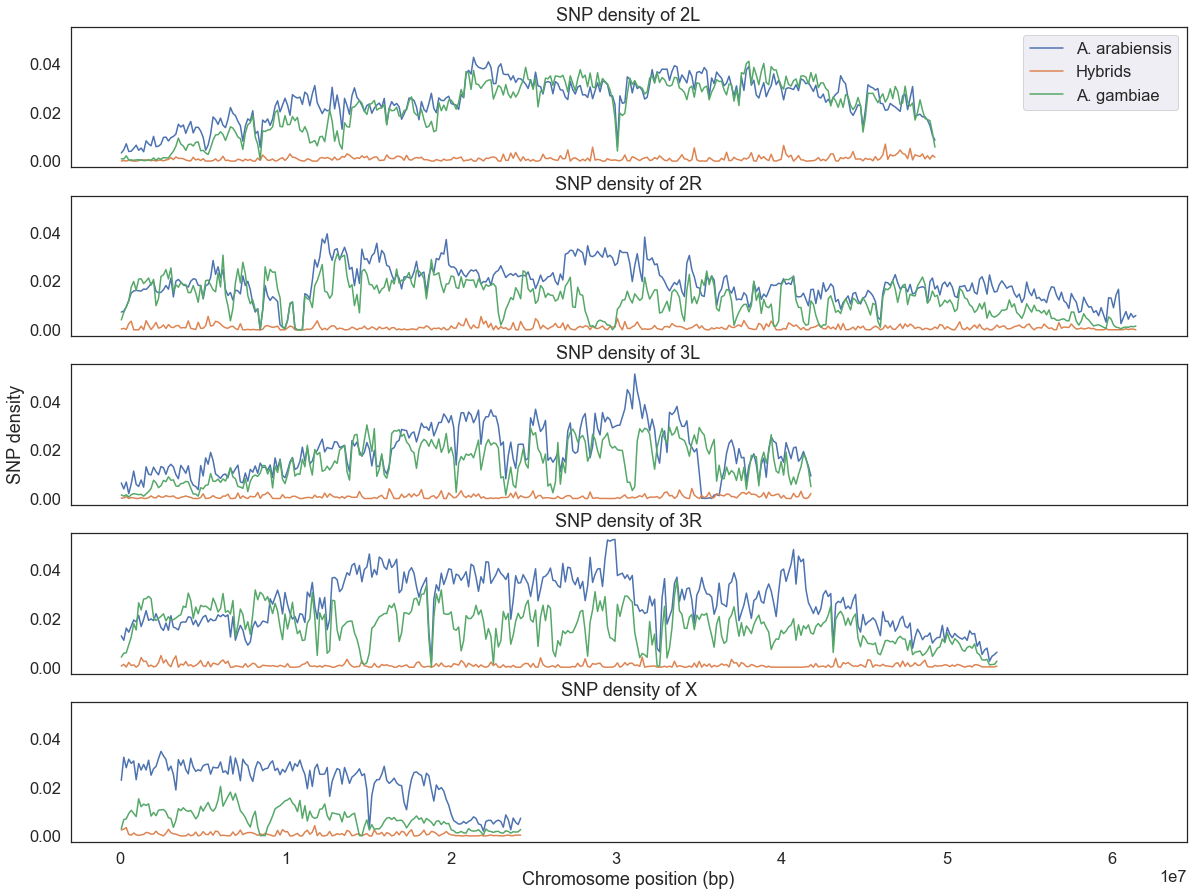

In [9]:
import matplotlib.pyplot as plt

import seaborn as sns

ds = sg.load_dataset('/Users/christinagkertsou/Desktop/Desktop March/FYP_new_x/dataset/AgamP4_2L.zarr')
ds1 = sg.load_dataset('/Users/christinagkertsou/Desktop/Desktop March/FYP_new_x/dataset/AgamP4_2R.zarr')
ds2 = sg.load_dataset('/Users/christinagkertsou/Desktop/Desktop March/FYP_new_x/dataset/AgamP4_3L.zarr')
ds3 = sg.load_dataset('/Users/christinagkertsou/Desktop/Desktop March/FYP_new_x/dataset/AgamP4_3R.zarr')
ds5 = sg.load_dataset('/Users/christinagkertsou/Desktop/Desktop March/FYP_new_x/dataset/AgamP4_X.zarr')

sns.set_style(style='white') 

result_dict_2L = plot_snp_density(ds, "AgamP4_2L",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)


fig, ax = plt.subplots(5, figsize=(20, 15), sharex=True, sharey=True)
sns.set(font_scale=1.5)


plot_cont=sns.lineplot(x=result_dict_2L['midpoints'], y=result_dict_2L['numpointscom_ara'], ax=ax[0], label="A. arabiensis")
plot_cont=sns.lineplot(x=result_dict_2L['midpoints'], y=result_dict_2L['numpointscom_hyb'], ax=ax[0], label="Hybrids")
plot_cont=sns.lineplot(x=result_dict_2L['midpoints'], y=result_dict_2L['numpointscom_gam'], ax=ax[0], label="A. gambiae")
plot_cont.set(xlabel=("Variant position (bp)"), title=(f"SNP density of 2L"))

result_dict_2R = plot_snp_density(ds1, "AgamP4_2R",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

plot_cont=sns.lineplot(x=result_dict_2R['midpoints'], y=result_dict_2R['numpointscom_ara'], ax=ax[1])
plot_cont=sns.lineplot(x=result_dict_2R['midpoints'], y=result_dict_2R['numpointscom_hyb'], ax=ax[1])
plot_cont=sns.lineplot(x=result_dict_2R['midpoints'], y=result_dict_2R['numpointscom_gam'], ax=ax[1])
plot_cont.set(xlabel=("Variant position (bp)"), title=(f"SNP density of 2R"))

result_dict_3L = plot_snp_density(ds2, "AgamP4_3L",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

plot_cont=sns.lineplot(x=result_dict_3L['midpoints'], y=result_dict_3L['numpointscom_ara'], ax=ax[2])
plot_cont=sns.lineplot(x=result_dict_3L['midpoints'], y=result_dict_3L['numpointscom_hyb'], ax=ax[2])
plot_cont=sns.lineplot(x=result_dict_3L['midpoints'], y=result_dict_3L['numpointscom_gam'], ax=ax[2])
plot_cont.set(xlabel=("Variant position (bp)"), ylabel=("SNP density"), title=(f"SNP density of 3L"))

result_dict_3R = plot_snp_density(ds3, "AgamP4_3R",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

plot_cont=sns.lineplot(x=result_dict_3R['midpoints'], y=result_dict_3R['numpointscom_ara'], ax=ax[3])
plot_cont=sns.lineplot(x=result_dict_3R['midpoints'], y=result_dict_3R['numpointscom_hyb'], ax=ax[3])
plot_cont=sns.lineplot(x=result_dict_3R['midpoints'], y=result_dict_3R['numpointscom_gam'], ax=ax[3])
plot_cont.set(xlabel=("Variant position (bp)"), title=(f"SNP density of 3R"))

result_dict_X = plot_snp_density(ds5, "AgamP4_X",  sizes_dict, "/Users/christinagkertsou/Desktop/Finalyearproject", 150_000)

plot_cont=sns.lineplot(x=result_dict_X['midpoints'], y=result_dict_X['numpointscom_ara'], ax=ax[4])
plot_cont=sns.lineplot(x=result_dict_X['midpoints'], y=result_dict_X['numpointscom_hyb'], ax=ax[4])
plot_cont=sns.lineplot(x=result_dict_X['midpoints'], y=result_dict_X['numpointscom_gam'], ax=ax[4])
plot_cont.set(xlabel=("Chromosome position (bp)"), title=(f"SNP density of X"))

In [10]:
import statistics
print(statistics.mean(result_dict_2L['numpointscom_ara']))
print(statistics.mean(result_dict_2L['numpointscom_hyb']))
print(statistics.mean(result_dict_2L['numpointscom_gam']))
print(statistics.mean(result_dict_2R['numpointscom_ara']))
print(statistics.mean(result_dict_2R['numpointscom_hyb']))
print(statistics.mean(result_dict_2R['numpointscom_gam']))
print(statistics.mean(result_dict_3L['numpointscom_ara']))
print(statistics.mean(result_dict_3L['numpointscom_hyb']))
print(statistics.mean(result_dict_3L['numpointscom_gam']))
print(statistics.mean(result_dict_3R['numpointscom_ara']))
print(statistics.mean(result_dict_3R['numpointscom_hyb']))
print(statistics.mean(result_dict_3R['numpointscom_gam']))
print(statistics.mean(result_dict_X['numpointscom_ara']))
print(statistics.mean(result_dict_X['numpointscom_hyb']))
print(statistics.mean(result_dict_X['numpointscom_gam']))

0.02495371833839919
0.0010135764944275583
0.022465086119554206
0.018872520325203253
0.0009949430894308944
0.012897365853658537
0.019910800477897252
0.0008027240143369176
0.014998805256869772
0.027012937853107346
0.000772467043314501
0.016869472693032014
0.022076666666666668
0.0007670781893004115
0.007349711934156378
